In [55]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

## Optimization problem to be studied

We will start studying functions of multiple variables by studying unconstrained optimization problems
$$
\begin{align}
\min \quad &f(x)\\
\text{s.t.}\quad &x\in \mathbb R^n
\end{align}  
$$

As an example, we study the optimization problem
$$
\begin{align}
\min \quad & (x_1-10)^2+(x_2+5)^2+x_1^2\\
\text{s.t.}\quad &x_1,x_2\in\mathbb R
\end{align}  
$$
This problem is unconstrained, because there are no constraints.

Now we need to define a function in Python that evaluates that function. That is, we define a two-variable function 
$$f:(x_1,x_2)\to (x_1-10)^2+(x_2+5)^2+x_1^2$$

In [56]:
def f_simple(x):
    return (x[0] - 10.0)**2 + (x[1] + 5.0)**2+x[0]**2

Now we can call that function

In [57]:
print "At point (3,-8) the value of the function is ",f_simple([3,-8])

At point (3,-8) the value of the function is  67.0


We can also plot that function

In [ ]:
import numpy as np
from pylab import meshgrid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_2d_function(lb1,lb2,ub1,ub2,f):
    x = np.arange(lb1,ub1,0.1)
    y = np.arange(lb2,ub2,0.1)
    X,Y = meshgrid(x, y) # grid of point
    Z = [f([x,y]) for (x,y) in zip (X,Y)] # evaluation of the function on the grid
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z)
    return plt

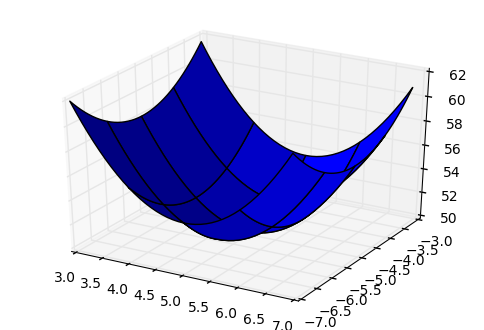

In [59]:
plot_2d_function(3,-7,7,-3,f_simple).show()

# Direct search methods

Direct search methods (also called pattern search methods) just rely on the function values to find a (local) optimum. Direct search methods consist of a set of  
1. exploratory moves that acquire information about the function $f$ in the neighbourhood of the current solution, and
2. pattern moves that attempt to speed up the search using the information acquired in the exploratory moves.

## Coordinate descent
Optimize function towards each coordinate direction separately, does not utilize pattern moves. 
* Slow convergence, especially when the level curves of the function are not along any of the coordinate axes 


## Hooke&Jeeves

**input:** a minimum step length $L>0$, initial step length $\epsilon_0$, constant $0<\delta<1$ for reducing the step length, exploratory step multiplier $\gamma>1$, and starting solution $x_0$  
**output:** an approximation of a local optimum (no guarantees of quality in general cases)  
```
set epsilon as the initial step length epsilon0
set x as the starting solution
while epsilon is greater than L:
    for each coordinate direction i:
        find the smallest of function values by incrementing and reducing the variable value in that coordinate by epsilon, let this value be xi*
    if x is the same as (x1*,...,xn*):
        reduce epsilon to delta*epsilon
    else:
        if the value of f at (x1*,...,xn*) is smaller than at x+gamma*((x1*,...,xn*)-x):
            set x as (x1*,...xn*)
        else:
            set x as x+gamma*((x1*,...,xn*)-x)
return x
        
```
Thus, the exploratory step of Hooke&Jeeves is performed by incrementing and reducing the variable to each coordinate direction and the pattern move is just a multiplication of the exploratory move.

![alt text](images/hooke&Jeeves.svg "Hooke&Jeeves")


In [60]:
import copy #Copying vectors
import numpy as np #Import vector calculus and much more!
def hookejeeves(L,epsilon0,delta,gamma,x0,f):
    #Set up the initial values
    epsilon = epsilon0
    x = np.array(x0)
    #Loop while step length greater than L:
    while epsilon>L:
        #our exploratory move is initially [0,..,0]
        xtest = np.zeros(len(x))
        for coordinate in range(len(x)):
            #First points to be explored are the all x, to be changed
            exp_points = [copy.copy(x) for _ in range(3)] #points to be explored
            #Change exp_points[0] and exp_points[1] to reflect
            #moving along the coordinate
            exp_points[0][coordinate]-=epsilon
            exp_points[1][coordinate]+=epsilon
            #Assign the function values given by exp_points to a list
            f_exp_points = [f(exp_point) for exp_point in exp_points]
            #pick the smallest one of them
            min_value = min(f_exp_points)
            #The exploratory move to the coordinate direction is given by the
            #move giving the smallest value of f
            xtest[coordinate] = exp_points[f_exp_points.index(min_value)][coordinate] #The coordinate value is the one where the minimum is attained
        #If no move at all, then reduce the exploratory move step size
        if all(xtest==x):
            epsilon = delta*epsilon
        else:
            #if exploratory move is better than pattern move
            if f(xtest)<f(x+gamma*(xtest-x)):
                #...set x as the exploratory move
                x = xtest
            else:
                #Otherwise we take the pattern move
                x = x+gamma*(xtest-x)
    return x

In [ ]:
L = 0.001
epsilon0 = 1
delta = 0.1
gamma = 2.0
start = [0.0,0.0]
#%timeit hookejeeves(L,epsilon0,delta,gamma,x0,f_simple)
x = hookejeeves(L,epsilon0,delta,gamma,start,f_simple); print "Optimal solution is" + str(x)

### How does it actually work?

Let us define a function that can plot a set of steps:

In [62]:
%pylab inline
import matplotlib.pyplot as plt

def plot_2d_steps(steps,start):
    myvec = np.array([start]+steps).transpose()
    plt.plot(myvec[0,],myvec[1,],'ro')
    for label,x,y in zip([str(i) for i in range(len(steps)+1)],myvec[0,],myvec[1,]):
        plt.annotate(label,xy = (x, y))
    return plt

Populating the interactive namespace from numpy and matplotlib


Now we need to save the steps of the algorithm. For that, let us modify the algorithm slightly:

In [63]:
import copy #Copying vectors
import numpy as np #Import vector calculus and much more!
def hookejeeves_savesteps(L,epsilon0,delta,gamma,x0,f):
    epsilon = epsilon0
    x = np.array(x0)
    steps = []
    while epsilon>L:
        xtest = np.zeros(len(x))
        for coordinate in range(len(x)):
            exp_points = [copy.copy(x) for _ in range(3)] #points to be explored
            exp_points[0][coordinate]-=epsilon
            exp_points[1][coordinate]+=epsilon
            f_exp_points = [f(exp_point) for exp_point in exp_points]
            min_value = min(f_exp_points)
            xtest[coordinate] = exp_points[f_exp_points.index(min_value)][coordinate] #The coordinate value is the one where the minimum is attained
        if all(xtest==x):
            epsilon = delta*epsilon
        else:
            if f(xtest)<f(x+gamma*(xtest-x)):
                x = xtest
            else:
                x = x+gamma*(xtest-x)
            steps.append(x)
    return x,steps

In [64]:
L = 0.001
epsilon0 = 1.0
delta = 0.1
gamma = 2
start = [0.,0.]
(x,steps) = hookejeeves_savesteps(L,epsilon0,delta,gamma,start,f_simple)

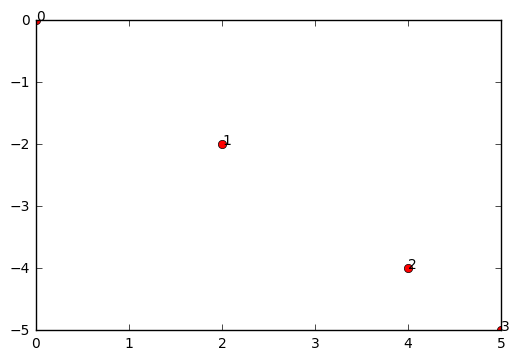

In [65]:
plot_2d_steps(steps,start).show()

## Powell's method

Powell's method is similar to Hooke&Jeeves, but the first step in exploratory moves is taken to the direction of the last pattern move. This speeds up the convergence in most cases.


In [ ]:
import copy
import numpy as np
def powell(L,epsilon0,delta,gamma,x0,f):
    epsilon = epsilon0
    exp_direction = np.array([0,1])
    x = np.array(x0)
    while epsilon>L:
        #Comparing among exploratory points to first exploratory direction:
        if f(x+exp_direction)<f(x):
            exp_step1=exp_direction
        elif f(x-exp_direction)<f(x):
            exp_step1=-exp_direction
        else:
            exp_step1 = np.zeros(2)
        #The following only works in 2d!!
        exp_direction2 = np.array([exp_direction[1],-exp_direction[0]]) # conjugate directions
        if f(x+exp_direction2)<f(x):
            exp_step2=exp_direction2
        elif f(x-exp_direction2)<f(x):
            exp_step2=-exp_direction2
        else:
            exp_step2 = np.zeros(2)
        if all(exp_step1+exp_step2==0):
            epsilon = delta*epsilon
        else:
            if f(x+(exp_step1+exp_step2))<f(x+gamma*(exp_step1+exp_step2)):
                x = x+(exp_step1+exp_step2)
            else:
                x = x+gamma*(exp_step1+exp_step2)
            exp_direction = epsilon*(exp_step1+exp_step2)/np.linalg.norm(exp_step1+exp_step2)
    return x

In [ ]:
L = 0.001
epsilon0 = 1.
delta = 0.1
gamma = 2.0
start = [0.,0.]
#%timeit powell(L,epsilon0,delta,gamma,x0,f_simple)
x = powell(L,epsilon0,delta,gamma,start,f_simple)
print "Optimal solution is" + str(x)

### How does it actually work?

Let us again modify the algorithm slightly:

In [ ]:
import copy
import numpy as np
def powell_savesteps(L,epsilon0,delta,gamma,x0,f):
    epsilon = epsilon0
    exp_direction = np.array([0,1])
    x = np.array(x0)
    steps = []
    while epsilon>L:
        exp_direction=epsilon*exp_direction
        #Comparing among exploratory points to firtst exploratory direction:
        if f(x+exp_direction)<f(x):
            exp_step1=exp_direction
        elif f(x-exp_direction)<f(x):
            exp_step1=-exp_direction
        else:
            exp_step1 = np.zeros(2)
        #The following only works in 2d!!
        exp_direction2 = np.array([exp_direction[1],-exp_direction[0]])
        if f(x+exp_direction2)<f(x):
            exp_step2=exp_direction2
        elif f(x-exp_direction2)<f(x):
            exp_step2=-exp_direction2
        else:
            exp_step2 = np.zeros(2)
        if all(exp_step1+exp_step2==0):
            epsilon = delta*epsilon
        else:
            if f(x+(exp_step1+exp_step2))<f(x+gamma*(exp_step1+exp_step2)):
                x = x+(exp_step1+exp_step2)
            else:
                x = x+gamma*(exp_step1+exp_step2)
            steps.append(x)
            exp_direction = (exp_step1+exp_step2)/np.linalg.norm(exp_step1+exp_step2)
    return x,steps

In [ ]:
L = 0.001
epsilon0 = 10
delta = 0.01
gamma = 2.0
start = [-2.,1.]
(x,steps) = powell_savesteps(L,epsilon0,delta,gamma,start,f_simple)

In [ ]:
plot_2d_steps(steps,start).show()

Another example
$$
\begin{align}
\min \quad & (x_1-2)^4+(x_1 - 2x_2)^2\\
\text{s.t.}\quad &x_1,x_2\in\mathbb R
\end{align}  
$$
Optimal solution clearly is $x^*=(2,1)^T$

In [ ]:
def f_simple2(x):
    return (x[0] - 2.0)**4 + (x[0] - 2.0*x[1])**2

In [ ]:
plot_2d_function(-2,-6,6,4,f_simple2).show()

In [ ]:
# Hooke & Jeeves
L = 0.001
epsilon0 = 1.0
delta = 0.1
gamma = 2
start = [0.5,0.5]
(x,steps) = hookejeeves_savesteps(L,epsilon0,delta,gamma,start,f_simple2)

In [ ]:
plot_2d_steps(steps,start).show()

In [ ]:
# Powell
L = 0.001
epsilon0 = 10
delta = 0.01
gamma = 2.0
start = [0.5,0.5]
(x,steps) = powell_savesteps(L,epsilon0,delta,gamma,start,f_simple2)

In [ ]:
plot_2d_steps(steps,start).show()